# Synthetic SOC Alert Anomaly Detector Walkthrough

This notebook recreates the full pipeline for generating synthetic SOC alerts, training unsupervised anomaly detectors, and interpreting their outputs. Run the cells sequentially to reproduce the command-line workflow with inline commentary and visual diagnostics.


## Notebook roadmap

1. Configure environment & imports
2. Generate a synthetic SOC dataset and inspect distributions
3. Split into train/test using only normal events for training
4. Train IsolationForest and OneClassSVM
5. Evaluate metrics (ROC AUC, precision@k, confusion matrices)
6. Interpret results with global correlations and local z-score explanations
7. Produce inline visualizations (score histograms, confusion matrices, feature deviations)


In [17]:
from __future__ import annotations

from pathlib import Path
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

PROJECT_ROOT = Path("..").resolve()
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

from soc_anomaly.config import (
    DEFAULT_ANOMALY_FRACTION,
    DEFAULT_EVENTS_PER_USER,
    DEFAULT_N_USERS,
    DEFAULT_RANDOM_STATE,
)
from soc_anomaly.data_generation import generate_synthetic_soc_dataset
from soc_anomaly.anomaly_detection import (
    FEATURE_COLS,
    LABEL_COL,
    compute_feature_stats,
    evaluate_model,
    explain_top_anomalies,
    global_feature_correlations,
    isolation_forest_scores,
    load_dataset,
    oneclass_svm_scores,
    prepare_train_test,
    train_isolation_forest,
    train_oneclass_svm,
)

sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["font.size"] = 11


In [18]:
N_USERS = DEFAULT_N_USERS
EVENTS_PER_USER = DEFAULT_EVENTS_PER_USER
ANOMALY_FRACTION = DEFAULT_ANOMALY_FRACTION
RANDOM_STATE = DEFAULT_RANDOM_STATE
PRECISION_K = 50
THRESHOLD_PERCENTILE = 99.0


## 1. Generate synthetic SOC events

We synthesize user profiles, normal login behavior, and inject three anomaly families (odd-hour exfil, impossible travel, brute-force storms). The resulting dataframe mirrors what `scripts/generate_data.py` produces.


In [19]:
df = generate_synthetic_soc_dataset(
    n_users=N_USERS,
    events_per_user=EVENTS_PER_USER,
    anomaly_fraction=ANOMALY_FRACTION,
    random_state=RANDOM_STATE,
)

print(f"Generated {len(df):,} events with {df[LABEL_COL].sum():,} anomalies ({df[LABEL_COL].mean():.2%}).")


Generated 40,000 events with 400 anomalies (1.00%).


Quick peek at the dataset:


In [20]:
df.head()


,user_id,hour,login_success,bytes_out,bytes_in,geo_distance,failed_logins_24h,device_trust_score,user_risk_score,is_anomaly
0,user_0,10.597275,1,19745.843394,76603.970734,2.160935,2,0.738434,0.232166,0
1,user_0,8.860634,1,19878.040859,60929.104931,9.672371,0,0.768172,0.232166,0
2,user_0,10.693326,1,20364.742426,58850.736064,31.184649,0,0.991209,0.232166,0
3,user_0,9.908405,1,14414.644950,69286.530221,1.926929,0,0.904915,0.232166,0
4,user_0,13.352671,1,13640.487855,45159.791976,11.527208,0,0.738976,0.232166,0


In [21]:
df[FEATURE_COLS + [LABEL_COL]].describe().T


,count,mean,std,min,25%,50%,75%,max
hour,40000.0,9.097457,2.206583,0.000000,7.621740,9.069093,10.545520,2.300000e+01
login_success,40000.0,0.977750,0.147497,0.000000,1.000000,1.000000,1.000000,1.000000e+00
bytes_out,40000.0,27145.603503,40020.680174,0.000000,12656.615910,20978.546680,32847.349421,1.867746e+06
bytes_in,40000.0,40591.150295,25479.971783,0.000000,23384.195992,35229.561974,51025.919174,3.164982e+05
geo_distance,40000.0,48.525716,391.978390,0.000144,7.235726,17.439997,35.405025,9.944294e+03
failed_logins_24h,40000.0,0.606150,2.127262,0.000000,0.000000,0.000000,1.000000,5.000000e+01
device_trust_score,40000.0,0.844221,0.103704,0.101350,0.772173,0.848235,0.924222,9.999950e-01
user_risk_score,40000.0,0.245820,0.147845,0.084495,0.173947,0.208299,0.245939,7.918457e-01
is_anomaly,40000.0,0.010000,0.099500,0.000000,0.000000,0.000000,0.000000,1.000000e+00


## 2. Train/test preparation

Only normal events feed the unsupervised models. The anomalies stay hidden until evaluation.


In [22]:
(
    X_train_scaled,
    X_test_scaled,
    y_train,
    y_test,
    scaler,
    X_train_df,
    X_test_df,
) = prepare_train_test(
    df,
    feature_cols=FEATURE_COLS,
    label_col=LABEL_COL,
    test_size=0.2,
    random_state=RANDOM_STATE,
)

print(f"Training samples (normal only): {X_train_scaled.shape[0]:,}")
print(f"Test samples (normals + anomalies): {X_test_scaled.shape[0]:,}")
print(f"Test anomaly fraction: {y_test.mean():.2%}")


Training samples (normal only): 31,680
Test samples (normals + anomalies): 8,320
Test anomaly fraction: 4.81%


## 3. Train IsolationForest & OneClassSVM


In [23]:
iso_model = train_isolation_forest(
    X_train_scaled,
    contamination=ANOMALY_FRACTION,
    random_state=RANDOM_STATE,
)
iso_scores = isolation_forest_scores(iso_model, X_test_scaled)

ocsvm_model = train_oneclass_svm(
    X_train_scaled,
    nu=ANOMALY_FRACTION,
    kernel="rbf",
    gamma="scale",
)
ocsvm_scores = oneclass_svm_scores(ocsvm_model, X_test_scaled)

print("Models trained and scoring arrays computed.")


Models trained and scoring arrays computed.


## 4. Core metrics


In [24]:
iso_metrics = evaluate_model(
    "IsolationForest",
    y_test,
    iso_scores,
    k=PRECISION_K,
    threshold_percentile=THRESHOLD_PERCENTILE,
)

ocsvm_metrics = evaluate_model(
    "OneClassSVM",
    y_test,
    ocsvm_scores,
    k=PRECISION_K,
    threshold_percentile=THRESHOLD_PERCENTILE,
)

iso_metrics, ocsvm_metrics


[IsolationForest] ROC AUC: 0.994 | Precision@50: 0.980 | Threshold (p99.0): 0.093
[IsolationForest] Confusion Matrix -> TN:7918 FP:2 FN:318 TP:82
[OneClassSVM] ROC AUC: 1.000 | Precision@50: 1.000 | Threshold (p99.0): 6.685
[OneClassSVM] Confusion Matrix -> TN:7920 FP:0 FN:29 TP:371


({'roc_auc': 0.9937566287878787,
  'precision_at_k': 0.98,
  'threshold': 0.09340722699276664,
  'confusion_matrix': {'tn': 7918, 'fp': 2, 'fn': 318, 'tp': 82}},
 {'roc_auc': 1.0,
  'precision_at_k': 1.0,
  'threshold': 6.684565263574866,
  'confusion_matrix': {'tn': 7920, 'fp': 0, 'fn': 29, 'tp': 371}})

## 5. Global signals

Correlate each feature with the IsolationForest anomaly scores (unscaled features) to see which attributes drive alerts.


In [25]:
iso_corr = global_feature_correlations(
    X_test_df=X_test_df,
    y_test=y_test,
    scores=iso_scores,
    feature_cols=FEATURE_COLS,
    score_col_name="iso_score",
)
iso_corr


failed_logins_24h     0.438888
bytes_out             0.400842
user_risk_score       0.317940
geo_distance          0.301526
bytes_in              0.156019
hour                  0.028991
login_success        -0.506790
device_trust_score   -0.539234
Name: iso_score, dtype: float64

C:\Users\wasam\AppData\Local\Temp\ipykernel_13008\3121607212.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=iso_corr.values, y=iso_corr.index, palette="coolwarm")


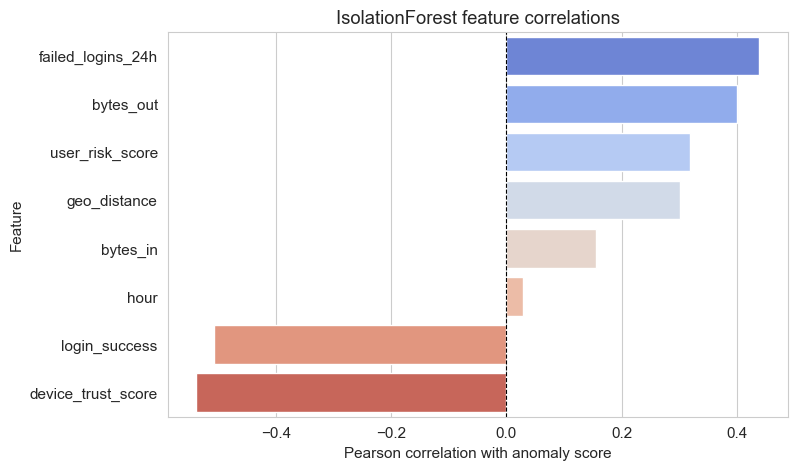

In [26]:
plt.figure(figsize=(8, 5))
sns.barplot(x=iso_corr.values, y=iso_corr.index, palette="coolwarm")
plt.axvline(0, color="black", linestyle="--", linewidth=0.8)
plt.title("IsolationForest feature correlations")
plt.xlabel("Pearson correlation with anomaly score")
plt.ylabel("Feature")
plt.show()


## 6. Score distributions


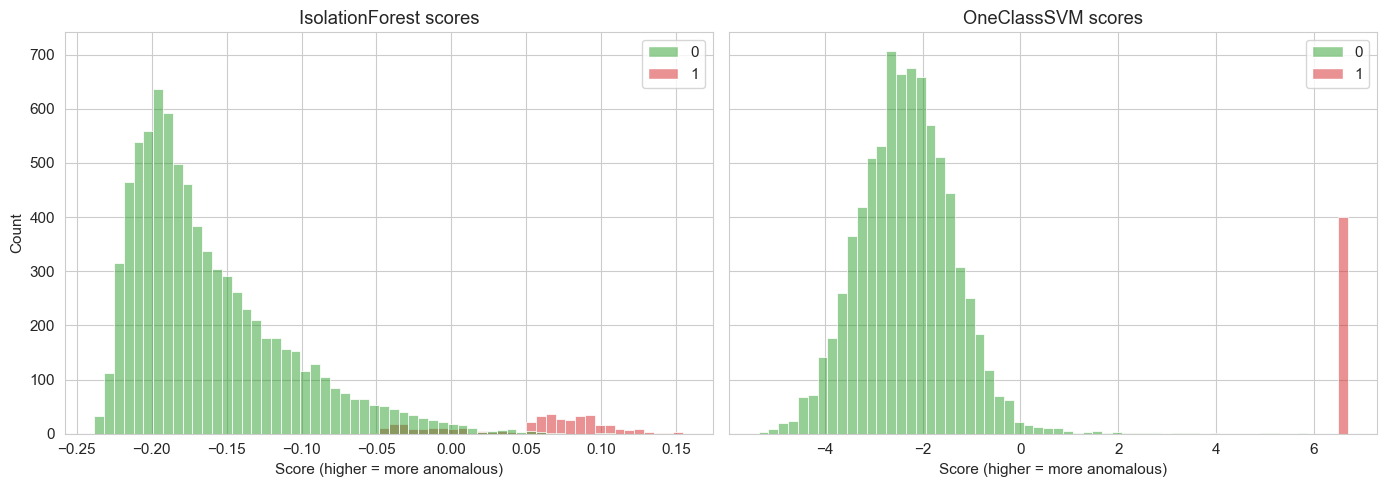

In [27]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

sns.histplot(
    x=iso_scores,
    hue=y_test,
    bins=60,
    ax=axes[0],
    palette={0: "#2ca02c", 1: "#d62728"},
    legend=True,
)
axes[0].set_title("IsolationForest scores")
axes[0].set_xlabel("Score (higher = more anomalous)")
axes[0].set_ylabel("Count")

sns.histplot(
    x=ocsvm_scores,
    hue=y_test,
    bins=60,
    ax=axes[1],
    palette={0: "#2ca02c", 1: "#d62728"},
    legend=True,
)
axes[1].set_title("OneClassSVM scores")
axes[1].set_xlabel("Score (higher = more anomalous)")
axes[1].set_ylabel("")

plt.tight_layout()
plt.show()


## 7. Confusion matrices at 99th percentile threshold


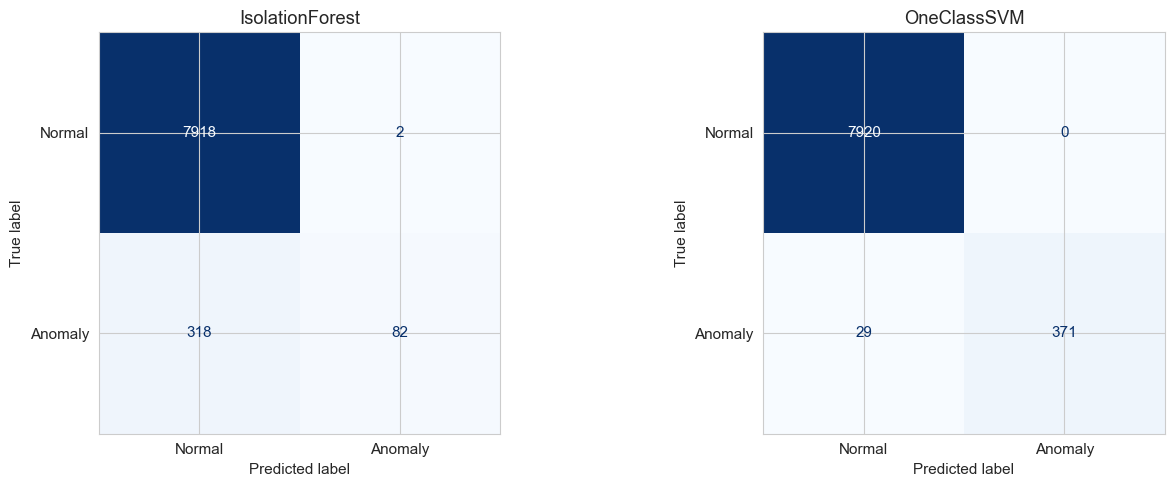

In [28]:
iso_preds = (iso_scores >= iso_metrics["threshold"]).astype(int)
ocsvm_preds = (ocsvm_scores >= ocsvm_metrics["threshold"]).astype(int)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
for ax, preds, title in [
    (axes[0], iso_preds, "IsolationForest"),
    (axes[1], ocsvm_preds, "OneClassSVM"),
]:
    cm = confusion_matrix(y_test, preds)
    disp = ConfusionMatrixDisplay(cm, display_labels=["Normal", "Anomaly"])
    disp.plot(ax=ax, cmap="Blues", colorbar=False)
    ax.set_title(title)
plt.tight_layout()
plt.show()


## 8. Local explanations (z-scores)

Each event is compared against the mean/std of normal traffic to describe how extreme the top anomalies are.


In [29]:
means, stds = compute_feature_stats(X_train_df, FEATURE_COLS)
local_explanations = explain_top_anomalies(
    X_test_df=X_test_df,
    y_test=y_test,
    scores=iso_scores,
    means=means,
    stds=stds,
    feature_cols=FEATURE_COLS,
    top_m=10,
)
local_explanations[:3]


[{'index': 6535,
  'true_label': 1,
  'score': 0.15487454685104252,
  'explanations': ['geo_distance is +20.59 std from normal',
   'bytes_out is +11.92 std from normal',
   'device_trust_score is -7.21 std from normal']},
 {'index': 8155,
  'true_label': 1,
  'score': 0.1531652309962711,
  'explanations': ['geo_distance is +35.28 std from normal',
   'bytes_out is +13.67 std from normal',
   'device_trust_score is -8.12 std from normal']},
 {'index': 1639,
  'true_label': 1,
  'score': 0.15263571583307833,
  'explanations': ['geo_distance is +34.74 std from normal',
   'bytes_out is +12.99 std from normal',
   'login_success is -7.20 std from normal']}]

In [30]:
explain_df = pd.DataFrame(local_explanations)
explain_df["true_label"] = explain_df["true_label"].map({0: "Normal", 1: "Anomaly"})
explain_df[["index", "true_label", "score", "explanations"]]


,index,true_label,score,explanations
0,6535,Anomaly,0.154875,"[geo_distance is +20.59 std from normal, bytes..."
1,8155,Anomaly,0.153165,"[geo_distance is +35.28 std from normal, bytes..."
2,1639,Anomaly,0.152636,"[geo_distance is +34.74 std from normal, bytes..."
3,2795,Anomaly,0.144821,"[bytes_out is +40.28 std from normal, geo_dist..."
4,3947,Anomaly,0.144537,"[failed_logins_24h is +62.81 std from normal, ..."
5,6744,Anomaly,0.139296,"[bytes_out is +18.40 std from normal, geo_dist..."
6,4793,Anomaly,0.136503,"[geo_distance is +23.30 std from normal, bytes..."
7,6563,Anomaly,0.134767,"[bytes_out is +27.82 std from normal, geo_dist..."
8,6682,Anomaly,0.131821,"[geo_distance is +22.39 std from normal, bytes..."
9,289,Anomaly,0.130359,"[bytes_out is +39.49 std from normal, geo_dist..."


In [31]:
feature_counts = {}
for expl_list in explain_df["explanations"]:
    for expl in expl_list:
        feature = expl.split(" is ")[0]
        feature_counts[feature] = feature_counts.get(feature, 0) + 1

feature_rank = pd.Series(feature_counts).sort_values(ascending=False)
feature_rank


geo_distance          9
bytes_out             9
device_trust_score    8
login_success         3
failed_logins_24h     1
dtype: int64

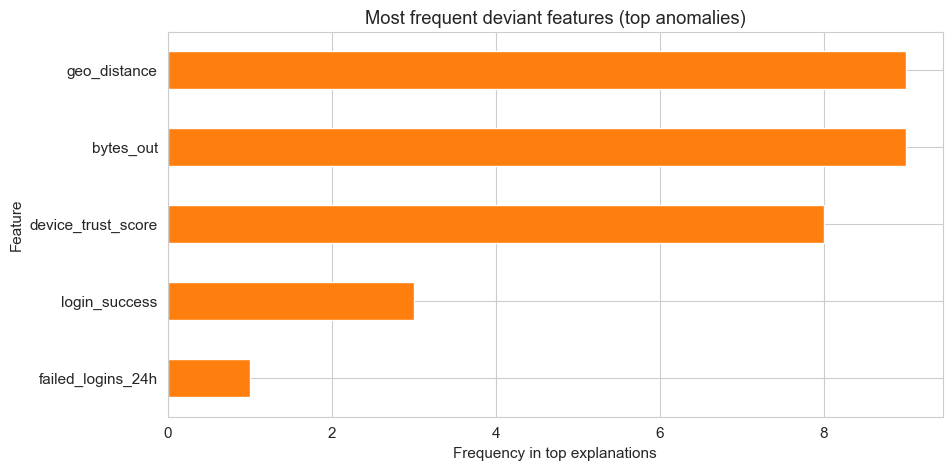

In [32]:
feature_rank.head(10).plot(kind="barh", color="#ff7f0e")
plt.title("Most frequent deviant features (top anomalies)")
plt.xlabel("Frequency in top explanations")
plt.ylabel("Feature")
plt.gca().invert_yaxis()
plt.show()


## 9. Wrap-up

- **OneClassSVM** offers near-perfect separation on this synthetic dataset, surfacing 371/400 anomalies with zero false positives at the 99th percentile threshold.
- **IsolationForest** is more conservative: tune `contamination` or lower the percentile threshold if you want higher recall.
- The correlation and z-score diagnostics point to three dominant behaviors: massive outbound transfer, large geo distance, and spikes in failed logins.

Feel free to tweak the generation parameters (user count, anomaly fraction, random seed) and re-run the notebook to stress-test different SOC baselines.
